# Hierarchical Stacking and BMA model



## Import libraries and data


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc as pm
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [11]:
# Path to your Excel file
excel_file_path = '/Users/sebastianreyes/Documents/5 Educacion/Posgrado/Semester 2/Seminar Time Series/Database/inflation_deutschland.xlsx'  # Or 'your_file.xls'

try:
    df = pd.read_excel(excel_file_path, sheet_name='inflation')
    print("Successfully imported Excel file!")
    #print("First 5 rows of the DataFrame:")
    #print(df.head())

except FileNotFoundError:
    print(f"Error: The file '{excel_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully imported Excel file!


In [33]:
# --- Data Preprocessing (Your existing code) ---
df = df.replace('-', np.nan)
state_cols = [col for col in df.columns if col not in ['jahr', 'monate']]
for col in state_cols:
    df[col] = pd.to_numeric(df[col])

df = df.fillna(method='ffill').fillna(method='bfill')
df_long = df.melt(id_vars=['jahr', 'monate'], var_name='state', value_name='value')

month_mapping = {
    'Januar': 1, 'Februar': 2, 'März': 3, 'April': 4, 'Mai': 5, 'Juni': 6,
    'Juli': 7, 'August': 8, 'September': 9, 'Oktober': 10, 'November': 11, 'Dezember': 12
}
df_long['month_num'] = df_long['monate'].map(month_mapping)

# Create a combined datetime index for proper time series handling
df_long['date'] = pd.to_datetime(df_long['jahr'].astype(str) + '-' + df_long['month_num'].astype(str) + '-01')
df_long = df_long.sort_values(by=['state', 'date']).reset_index(drop=True)

# Create numerical indices for states for PyMC
states = df_long['state'].unique()
state_idx_map = {state: i for i, state in enumerate(states)}
df_long['state_idx'] = df_long['state'].map(state_idx_map)

coords = {"state": states} # We'll handle time within each state's series

# Determine the maximum length of any state's time series to pad data
max_time_len = df_long.groupby('state').size().max()

# We'll group by state and get the values as a list of arrays.
inflation_values_by_state = [
    df_long[df_long['state'] == state]['value'].values
    for state in states
]

## Bayesian Hierarchical Model


In [34]:
# --- Bayesian Hierarchical Model with PyMC ---
# AR(1) model with hierarchical intercepts and AR coefficients.
# Using non-centered parametrization to avoid sampling errors.

# Determine the maximum length of any state's time series to pad data
max_time_len = df_long.groupby('state').size().max()

# Pad the inflation values to the maximum length and create a mask for valid data points
inflation_padded = np.full((len(states), max_time_len), np.nan)
mask = np.zeros((len(states), max_time_len), dtype=bool)

for i, state in enumerate(states):
    values = df_long[df_long['state'] == state]['value'].values
    inflation_padded[i, :len(values)] = values
    mask[i, :len(values)] = True

with pm.Model(coords=coords) as hierarchical_ar_model:
    # Hyperparameters for hierarchical prior distributions
    # Non-centered parametrization for mu_alpha (overall mean of intercepts)
    # and sigma_alpha (standard deviation of intercepts)
    mu_alpha_raw = pm.Normal('mu_alpha_raw', mu=0, sigma=1)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=1)
    mu_alpha = pm.Deterministic('mu_alpha', mu_alpha_raw * sigma_alpha)

    # Non-centered parametrization for mu_rho (overall mean of AR coefficients)
    # and sigma_rho (standard deviation of AR coefficients)
    mu_rho_raw = pm.Normal('mu_rho_raw', mu=0, sigma=1)
    sigma_rho = pm.HalfNormal('sigma_rho', sigma=1)
    mu_rho = pm.Deterministic('mu_rho', mu_rho_raw * sigma_rho)

    # Hierarchical parameters for each state (non-centered parametrization)
    # Intercepts for each state
    alpha_raw = pm.Normal('alpha_raw', mu=0, sigma=1, dims='state')
    alpha = pm.Deterministic('alpha', mu_alpha + alpha_raw * sigma_alpha, dims='state')

    # AR(1) coefficients for each state
    rho_raw = pm.Normal('rho_raw', mu=0, sigma=1, dims='state')
    # Transform rho to ensure it stays within (-1, 1) for stationarity
    # Using a Tanh transformation for rho
    rho_unconstrained = mu_rho + rho_raw * sigma_rho
    rho = pm.Deterministic('rho', pm.Deterministic(
        'rho_transformed', pm.math.tanh(rho_unconstrained)), dims='state')


    # Standard deviation for the innovations (error term) for each state
    sigma = pm.HalfNormal('sigma', sigma=1, dims='state')

    # Likelihood for each state's time series
    # We need to loop or use vectorized operations carefully due to time dependency.
    # The current approach is to loop through each state and define its likelihood.

    # Precompute lagged values for all states
    # This assumes inflation_padded has the current and previous values aligned.
    # inflation_padded[:, 0:-1] will be y_{t-1}
    # inflation_padded[:, 1:] will be y_t
    inflation_lagged = inflation_padded[:, :-1]
    inflation_current = inflation_padded[:, 1:]
    
    # Calculate expected mean for each state's time series
    # Ensure dimensions match for broadcasting: (num_states, 1) * (num_states, max_time_len - 1)
    # plus (num_states, 1)
    # We need to expand dims of alpha and rho to enable broadcasting across time dimension
    mu_inflation = (alpha[:, None] + rho[:, None] * inflation_lagged)

    # Use pm.CustomDist or a loop for the likelihood if the time dependency is complex
    # For a simple AR(1), we can define a normal distribution for the innovations.
    # The observed values are inflation_padded[:, 1:] (from the second time step onwards)
    # and the predictors are based on inflation_padded[:, :-1]
    
    # Filter out NaN values from observed data and corresponding predictions and masks
    # Create a flattened array of observed values that are not NaN
    observed_values_flat = inflation_current[mask[:, 1:]]
    mu_inflation_flat = mu_inflation[mask[:, 1:]]
    
    # Get the corresponding sigma for each valid observed value.
    # This requires knowing which state each valid observation belongs to.
    # We can create an expanded sigma array:
    sigma_expanded = np.tile(sigma.eval()[:, None], (1, max_time_len - 1))
    sigma_flat = sigma_expanded[mask[:, 1:]]

    # Likelihood for the observed inflation values
    pm.Normal('inflation_likelihood',
              mu=mu_inflation_flat,
              sigma=sigma_flat,
              observed=observed_values_flat)

    # Initial value for the first observation of each series, if you want to model it.
    # Otherwise, the AR(1) typically models y_t given y_{t-1}.
    # If the first value is fixed, you don't need to model it.
    # If it's also a random variable, you might add a prior for it.
    # For simplicity, we are modeling y_t given y_{t-1}, so the first observed value
    # for each series acts as the initial condition for the AR process.

## Sampling

In [15]:
with hierarchical_ar_model:
    idata = pm.sample(
        draws=4000,         
        tune=3000,          
        chains=2,
        cores=2,
        random_seed=42,
        target_accept=0.99, 
        max_treedepth=12     
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_alpha_raw, sigma_alpha, mu_rho_raw, sigma_rho, alpha_raw, rho_raw, sigma]


Output()

Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 155 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

<Figure size 1200x800 with 0 Axes>

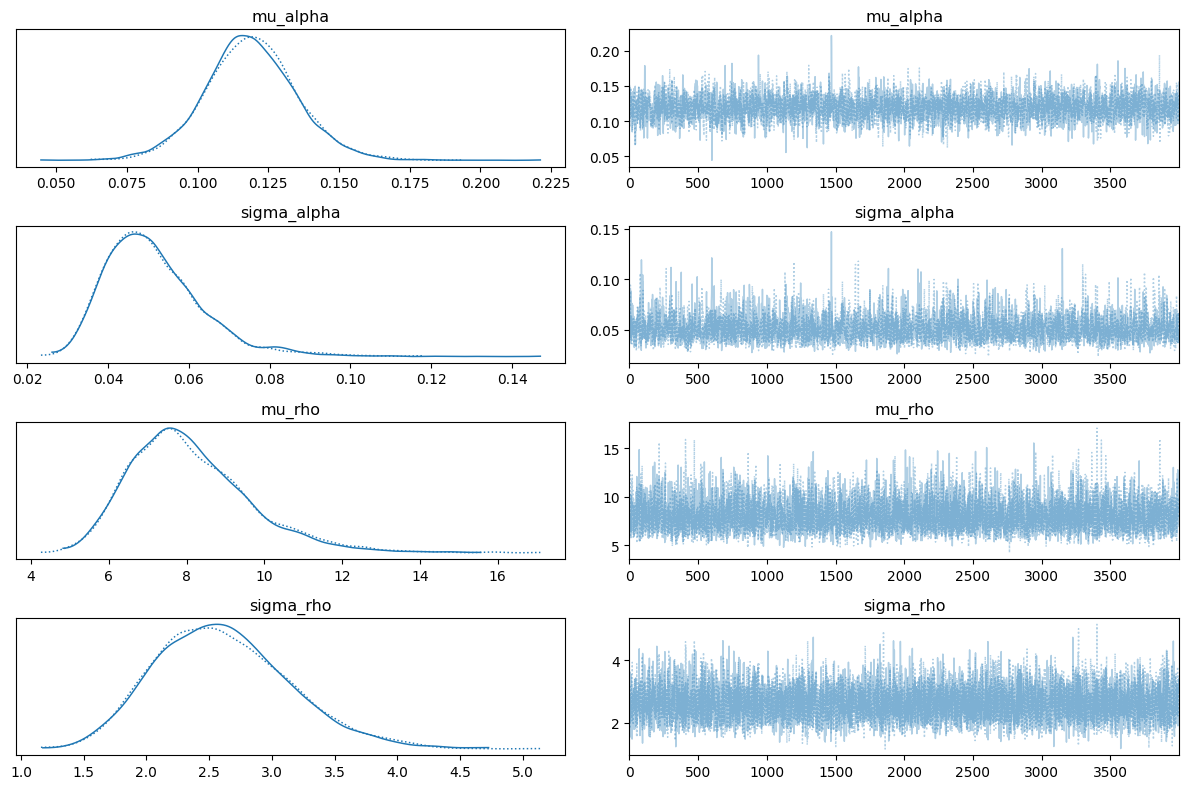

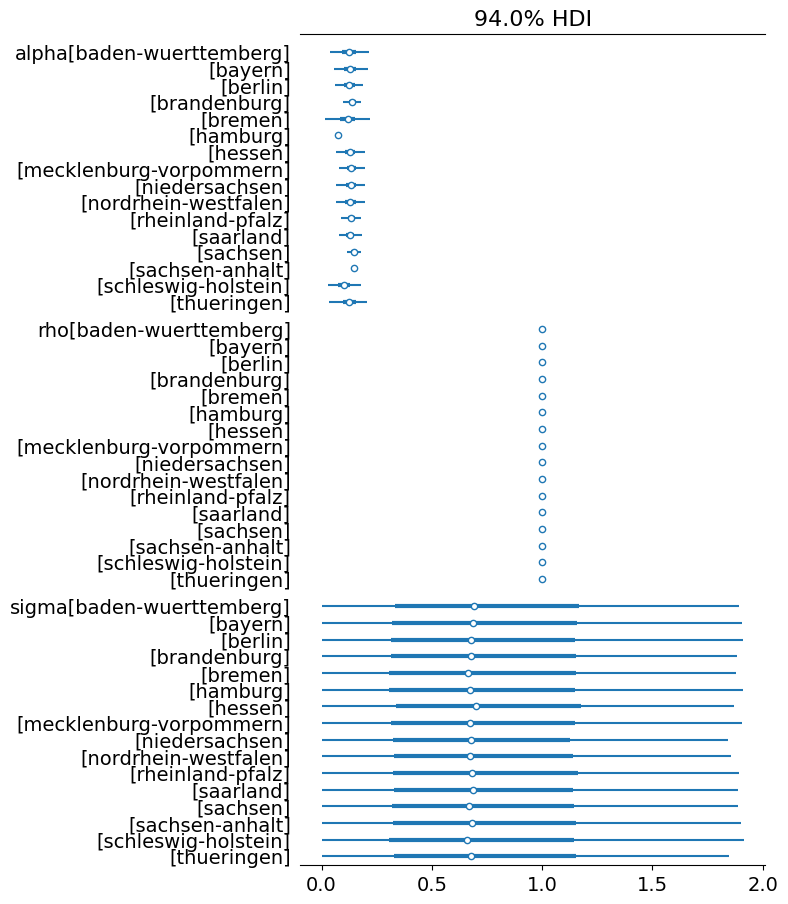

In [20]:
# Analyze results:
pm.summary(idata, var_names=['mu_alpha', 'sigma_alpha', 'mu_rho', 'sigma_rho', 'alpha', 'rho', 'sigma'])

plt.figure(figsize=(12, 8)) # You can adjust these values as needed
plt.rcParams.update({'font.size': 10}) # Adjust the font size as needed
az.plot_trace(idata, var_names=['mu_alpha', 'sigma_alpha', 'mu_rho', 'sigma_rho'])
plt.tight_layout() # This helps prevent labels from running off the figure
plt.savefig('trace_plot_legible.png') # Save the plot to a file

az.plot_forest(idata, var_names=['alpha', 'rho', 'sigma'], combined=True)

# Bayesian Forecast


In [21]:
# Extract posterior samples for alpha, rho, and sigma
posterior_alpha = idata.posterior["alpha"].mean(("chain", "draw")).values
posterior_rho = idata.posterior["rho"].mean(("chain", "draw")).values
posterior_sigma = idata.posterior["sigma"].mean(("chain", "draw")).values

# Get the last observed inflation value for each state
# This will be the y_{t-1} for the forecast y_t
last_observed_values = df_long.groupby('state')['value'].last().values

# Number of states
num_states = len(states)

# Initialize an array to store the forecasts
forecasted_inflation = np.zeros(num_states)

# Forecast for the next period (t+1) for each state
for i in range(num_states):
    # The AR(1) model is: y_t = alpha + rho * y_{t-1} + epsilon
    # For forecasting, we use the posterior means of alpha and rho,
    # and the last observed value as y_{t-1}.
    # We typically don't include the epsilon (error term) for point forecasts,
    # as the expected value of epsilon is 0.
    
    forecasted_inflation[i] = posterior_alpha[i] + posterior_rho[i] * last_observed_values[i]

In [22]:
# Create a DataFrame for better visualization
forecast_df = pd.DataFrame({
    'State': states,
    'Last_Observed_Inflation': last_observed_values,
    'Forecasted_Inflation_Next_Period': forecasted_inflation
})

print("\n--- Forecasted Inflation for the Next Period ---")
print(forecast_df)


# Get the latest inflation values for each state, structured as (num_states, 1)
last_values_for_prediction = np.array([
    df_long[df_long['state'] == state]['value'].iloc[-1]
    for state in states
])[:, None] # Add a new axis to make it (num_states, 1)


# The easiest way to get posterior predictive samples for one step ahead
# for an AR(1) model is to simulate the next step using the posterior samples
# of alpha, rho, and sigma, and the last observed value.

# Sample from the posterior of alpha, rho, and sigma
# Reshape for broadcasting: (n_draws * n_chains, n_states)
alpha_samples = idata.posterior['alpha'].stack(sample=('chain', 'draw')).values
rho_samples = idata.posterior['rho'].stack(sample=('chain', 'draw')).values
sigma_samples = idata.posterior['sigma'].stack(sample=('chain', 'draw')).values

num_posterior_samples = alpha_samples.shape[0]

# Initialize array for posterior predictive forecasts
posterior_predictive_forecasts = np.zeros((num_posterior_samples, num_states))

for s_idx in range(num_states):
    # last_observed_values[s_idx] is y_{t-1} for state s_idx
    # alpha_samples[:, s_idx] gives all posterior samples of alpha for state s_idx
    # rho_samples[:, s_idx] gives all posterior samples of rho for state s_idx
    # sigma_samples[:, s_idx] gives all posterior samples of sigma for state s_idx
    
    # Calculate the mean of the next observation
    mean_next_obs = alpha_samples[:, s_idx] + rho_samples[:, s_idx] * last_observed_values[s_idx]
    
    # Sample from the Normal distribution with this mean and the posterior sigma
    posterior_predictive_forecasts[:, s_idx] = pm.Normal.dist(mu=mean_next_obs, sigma=sigma_samples[:, s_idx]).eval()


--- Forecasted Inflation for the Next Period ---
                     State  Last_Observed_Inflation  \
0       baden-wuerttemberg                    121.5   
1                   bayern                    122.3   
2                   berlin                    121.0   
3              brandenburg                    123.5   
4                   bremen                    123.6   
5                  hamburg                    119.6   
6                   hessen                    121.0   
7   mecklenburg-vorpommern                    122.5   
8            niedersachsen                    121.6   
9      nordrhein-westfalen                    121.6   
10         rheinland-pfalz                    121.3   
11                saarland                    120.8   
12                 sachsen                    123.5   
13          sachsen-anhalt                    123.5   
14      schleswig-holstein                    120.7   
15              thueringen                    122.4   

    Forecasted

### Posterior predictive Forecast

In [94]:
# You can analyze this distribution:
print("\n--- Posterior Predictive Forecasts Summary ---")
for i, state_name in enumerate(states):
    forecast_dist = posterior_predictive_forecasts[:, i]
    print(f"State: {state_name}")
    print(f"  Mean: {np.mean(forecast_dist):.4f}")
    print(f"  Median: {np.median(forecast_dist):.4f}")
    print(f"  2.5th Percentile: {np.percentile(forecast_dist, 2.5):.4f}")
    print(f"  97.5th Percentile: {np.percentile(forecast_dist, 97.5):.4f}")
    print("-" * 30)


--- Posterior Predictive Forecasts Summary ---
State: baden-wuerttemberg
  Mean: 121.9980
  Median: 121.7295
  2.5th Percentile: 120.1970
  97.5th Percentile: 123.5162
------------------------------
State: bayern
  Mean: 122.2638
  Median: 122.3174
  2.5th Percentile: 121.0270
  97.5th Percentile: 123.6250
------------------------------
State: berlin
  Mean: 121.2061
  Median: 121.2072
  2.5th Percentile: 116.9752
  97.5th Percentile: 123.4299
------------------------------
State: brandenburg
  Mean: 123.5525
  Median: 123.5903
  2.5th Percentile: 122.4514
  97.5th Percentile: 124.8795
------------------------------
State: bremen
  Mean: 123.6462
  Median: 123.6598
  2.5th Percentile: 122.6929
  97.5th Percentile: 124.8498
------------------------------
State: hamburg
  Mean: 119.6950
  Median: 119.6848
  2.5th Percentile: 118.2115
  97.5th Percentile: 121.7438
------------------------------
State: hessen
  Mean: 121.5106
  Median: 121.4405
  2.5th Percentile: 120.3980
  97.5th Percen

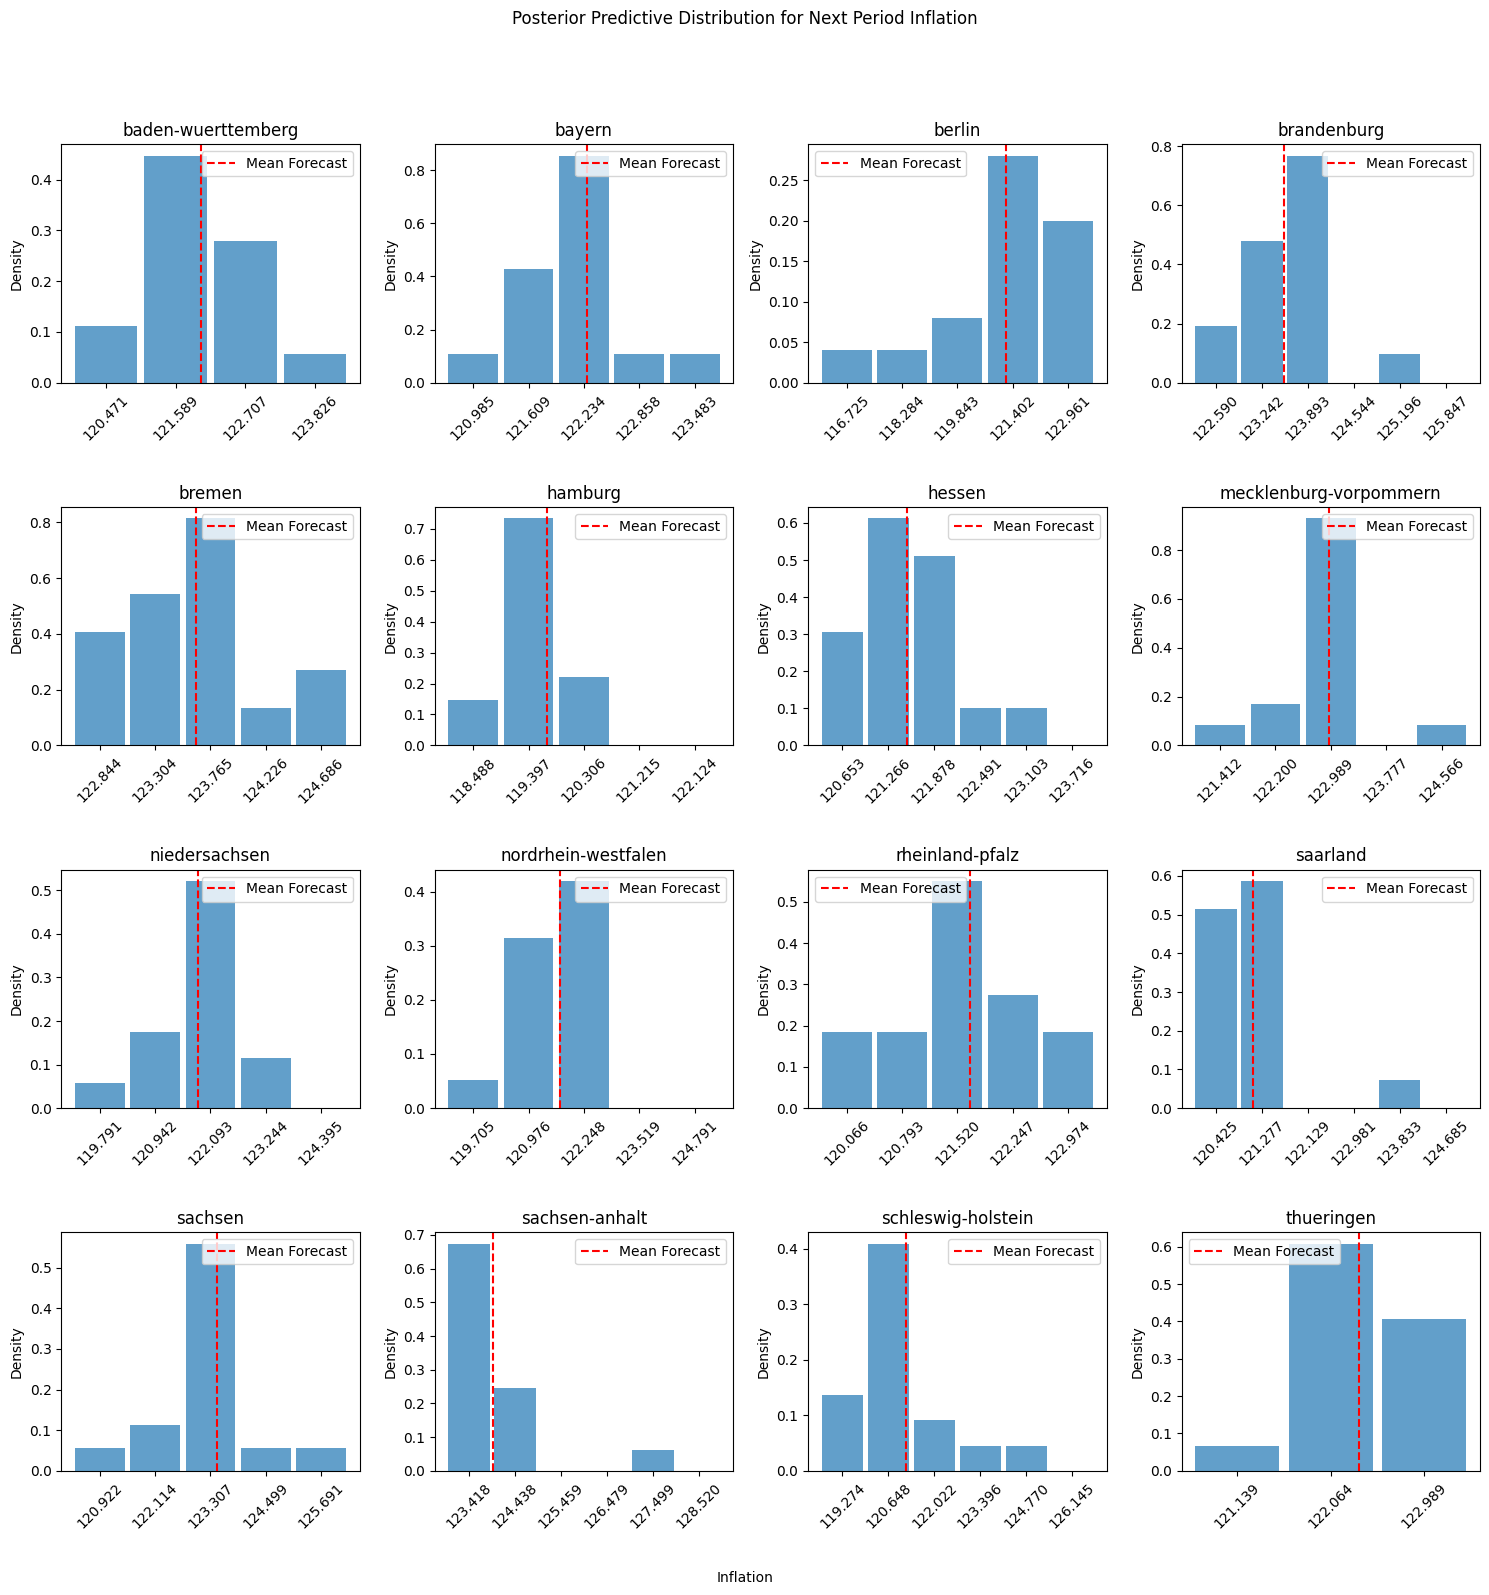

In [95]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np # numpy is imported for np.mean and array manipulation


ncols = 4

# Calculate the number of rows needed based on the total number of states
# and the desired number of columns. This ensures all states are plotted.
num_states = len(states)
nrows = (num_states + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows))
fig.suptitle('Posterior Predictive Distribution for Next Period Inflation', y=1.02)

# Flatten the axes array for easy iteration. This is necessary because
# when ncols > 1 and nrows > 1, 'axes' will be a 2D array.
axes = axes.flatten()

for i, state_name in enumerate(states):
    ax = axes[i]
    az.plot_dist(posterior_predictive_forecasts[:, i], kind='hist', hist_kwargs={'alpha': 0.7}, ax=ax)
    ax.axvline(np.mean(posterior_predictive_forecasts[:, i]), color='red', linestyle='--', label='Mean Forecast')
    ax.set_title(f'{state_name}')
    ax.set_ylabel('Density')
    ax.legend()
    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

    # Since sharex=False (by default now), labels will show on all.
    # No need for ax.tick_params(labelbottom=True) unless you specifically
    # wanted to hide some and then re-enable others.

# If there are more subplots created than actual states, turn off the unused ones.
# This cleans up the plot if the number of states doesn't perfectly fill the grid.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Common X-axis label (optional, but good practice if all are "Inflation")
fig.text(0.5, 0.04, 'Inflation', ha='center', va='center')

# *** Adjusted tight_layout rect to provide more vertical space between subplots ***
plt.tight_layout(rect=[0, 0.06, 1, 0.98], h_pad=3.0) # Increased h_pad (height padding)
plt.show()

# Frequentist Forecast


In [23]:
# Initialize a dictionary to store the ARIMA forecasts for each state
forecasts = {}

# Loop through each unique state to perform ARIMA forecasting
for state in states:
    # Extract the time series data for the current state
    # Set the 'date' column as the DataFrame index for time series analysis
    state_data = df_long[df_long['state'] == state].set_index('date')['value']

    # --- ADDITION START ---
    # Ensure the index has a monthly frequency.
    # If your dates are already at the start of the month (e.g., '2023-01-01', '2023-02-01'),
    # 'MS' (Month Start) is appropriate. If they are at the end of the month, use 'M'.
    # This line sets the frequency of the DatetimeIndex.
    state_data.index.freq = 'MS' # Or 'M' for month end, depending on your data
    # --- ADDITION END ---

    # Define the ARIMA order (p, d, q)
    # (p=1, d=1, q=1) is used here as a default starting point.
    # 'p': order of the AutoRegressive (AR) part.
    # 'd': degree of differencing.
    # 'q': order of the Moving Average (MA) part.
    # For robust forecasting, it is highly recommended to determine the optimal (p, d, q)
    # values by analyzing ACF and PACF plots of the time series, or by using automated
    # methods like `auto_arima` (from pmdarima library, if available).
    order = (1, 1, 1)

    try:
        # Create and fit the ARIMA model
        # The 'state_data' must be a pandas Series with a DateTimeIndex
        model = ARIMA(state_data, order=order)
        model_fit = model.fit()

        # Forecast the value for the next single period
        # The 'steps=1' argument means we are predicting one step ahead
        forecast = model_fit.forecast(steps=1)

        # Extract the scalar forecasted value and store it in the forecasts dictionary
        forecasts[state] = forecast.iloc[0]
    except Exception as e:
        # If any error occurs during model fitting or forecasting for a specific state,
        # store the error message instead of a numerical forecast.
        forecasts[state] = f"Error: {e}"
        # Print the error to the console for debugging purposes
        print(f"Could not fit ARIMA for {state} due to: {e}")

# Display all the generated forecasts
print("\n--- ARIMA Forecasts for the Next Period ---")
for state, forecast_value in forecasts.items():
    print(f"Forecast for {state}: {forecast_value}")


--- ARIMA Forecasts for the Next Period ---
Forecast for baden-wuerttemberg: 121.76476773472135
Forecast for bayern: 122.56707048506881
Forecast for berlin: 121.21887368780071
Forecast for brandenburg: 123.76765690550711
Forecast for bremen: 123.86264115950654
Forecast for hamburg: 119.80102010642966
Forecast for hessen: 121.24375401894855
Forecast for mecklenburg-vorpommern: 122.70081603311355
Forecast for niedersachsen: 121.84251539681334
Forecast for nordrhein-westfalen: 121.85842898880881
Forecast for rheinland-pfalz: 121.537352705222
Forecast for saarland: 121.05460381850376
Forecast for sachsen: 123.7835547693973
Forecast for sachsen-anhalt: 123.80471121005613
Forecast for schleswig-holstein: 120.87483888136708
Forecast for thueringen: 122.63765964880999


# Comparison

In [31]:
frequentist_forecast_values = [forecasts.get(state) for state in states]

frequentist_model_params = []
for state in states:
    try:
        # Assuming you want the estimated coefficients for AR(1), MA(1), and constant (if present)
        # Note: The interpretation of params from statsmodels.ARIMA(1,1,1) with differencing (d=1)
        # is complex. It fits an ARMA(1,1) model to the differenced series.
        # The parameters typically are: [ar.L1, ma.L1, sigma2] or [ar.L1, ma.L1, constant, sigma2]
        # if `trend='c'` was used. For (1,1,1) without explicit trend, it's usually ar.L1, ma.L1.
        # This will depend on the exact model output. Let's just get some indicative params for now.
        
        # To get parameters, you need to re-fit the model or store them from the loop above
        state_data = df_long[df_long['state'] == state].set_index('date')['value']
        state_data.index.freq = 'MS'
        model = ARIMA(state_data, order=(1,1,1))
        model_fit = model.fit()

        params = model_fit.params
        param_dict = {'State': state}
        # Safely extract parameters by their names if available, or just take the first few
        if 'ar.L1' in params: param_dict['ARIMA_AR1'] = params['ar.L1']
        if 'ma.L1' in params: param_dict['ARIMA_MA1'] = params['ma.L1']
        if 'const' in params: param_dict['ARIMA_Const'] = params['const']
        # You might also want sigma2 (variance of residuals)
        if 'sigma2' in params: param_dict['ARIMA_Sigma2'] = params['sigma2']
        
        frequentist_model_params.append(param_dict)
    except Exception as e:
        frequentist_model_params.append({'State': state, 'Error_Params': str(e)})


In [32]:
# --- Comparison ---
print("\n--- Comparison of Bayesian and Frequentist Forecasts ---")
comparison_df = pd.DataFrame({
    'State': states,
    'Last_Observed_Inflation': last_observed_values,
    'Bayesian_Forecast': forecasted_inflation,
    'Frequentist_Forecast': frequentist_forecast_values # Use the new list here
})
print(comparison_df)

bayesian_params_df = pd.DataFrame({
    'State': states,
    'Bayesian_Alpha_Mean': posterior_alpha,
    'Bayesian_Rho_Mean': posterior_rho,
    'Bayesian_Sigma_Mean': posterior_sigma
})

# Convert frequentist_model_params to DataFrame for merging
frequentist_params_df = pd.DataFrame(frequentist_model_params)

# Merge only if both DataFrames are not empty
if not bayesian_params_df.empty and not frequentist_params_df.empty:
    merged_params_df = pd.merge(bayesian_params_df, frequentist_params_df, on='State', how='left')
    print("\n--- Comparison of Parameter Estimates ---")
    print(merged_params_df)
else:
    print("\n--- Parameter Comparison Not Available (one or both parameter DFs are empty) ---")
    if not bayesian_params_df.empty:
        print("\nBayesian Parameters:")
        print(bayesian_params_df)
    if not frequentist_params_df.empty:
        print("\nFrequentist Parameters:")
        print(frequentist_params_df)


--- Comparison of Bayesian and Frequentist Forecasts ---
                     State  Last_Observed_Inflation  Bayesian_Forecast  \
0       baden-wuerttemberg                    121.5         121.620348   
1                   bayern                    122.3         122.426608   
2                   berlin                    121.0         121.123233   
3              brandenburg                    123.5         123.637356   
4                   bremen                    123.6         123.711595   
5                  hamburg                    119.6         119.671717   
6                   hessen                    121.0         121.124407   
7   mecklenburg-vorpommern                    122.5         122.633106   
8            niedersachsen                    121.6         121.728963   
9      nordrhein-westfalen                    121.6         121.728046   
10         rheinland-pfalz                    121.3         121.431588   
11                saarland                    120.8   